In [1]:
# coding: utf-8
# Please use Python 2.
# Check if all the required packages are installed.
# Please use Theano as backend of Keras.
# Using IPython or Jupyter Notebook to run this code is strongly recommended!
# Run line by line or block by block, and you can config some important parameters
# and output whatever you want!

In [2]:
import sys, os, collections, subprocess, re, csv
import nltk, codecs
import numpy as np
import pandas as pd
import pickle
import xml.etree.ElementTree as ET
from pandas import DataFrame, Series
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing.text import Tokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import ArabicStemmer
from util import *
from PairWiseRanker import *

Using TensorFlow backend.


In [3]:
from IPython.display import clear_output

In [4]:
from copy import deepcopy

In [5]:
% pylab inline

Populating the interactive namespace from numpy and matplotlib


c:\python35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
UNKNOWN_WORD = ':-)'

In [7]:
data_dir = 'data/'
fn = {'train':data_dir + 'SemEval2016-Task3-CQA-MD-train.xml', 'dev':data_dir + 'SemEval2016-Task3-CQA-MD-dev.xml', 'test':data_dir + 'SemEval2017-Task3-CQA-MD-test.xml'}

In [8]:
word2vec_dir = 'data/'
EMBEDDING_DIM = 128

In [9]:
def read_data(f):
    
    tree = ET.parse(f)
    root = tree.getroot()
    data = DataFrame()
    
    records = []
    
    for Question in root:
        QID = Question.get('QID')
        Qtext = Question.find('Qtext').text
        
        
        
        for QApair in Question.iter('QApair'): 
            record = {}
            
            QAID = QApair.get('QAID')
            QArel = 0 if QApair.get('QArel') == 'I' else 1
            QAconf = QApair.get('QAconf')
            QAquestion = QApair.find('QAquestion').text
            QAanswer = QApair.find('QAanswer').text
            
            record['QID'] = QID
            record['Qtext'] = Qtext
            record['QAID'] = QAID
            record['QAquestion'] = QAquestion
            record['QAanswer'] = QAanswer
            record['QArel'] = QArel
            record['QAconf'] = QAconf
            
            records.append(record)
      
    data = pd.DataFrame(records)
    data = data.drop_duplicates()
    data['ID'] = data['QID'] + '*' + data['QAID']
    data.index = data['ID']
    for col in ['Qtext', 'QAquestion']:
        data[col] = list(map(lambda x : x.lower(), data[col]))
    questions = dict(zip(data['QID'], data['Qtext']))
    return data, questions

In [10]:
data, questions = {}, {}
for k in fn:
    data[k], questions[k] = read_data(fn[k])
    print(k, data[k].shape, len(set(data[k]['QID'])))

train (30411, 8) 1031
dev (7384, 8) 250
test (12581, 8) 1400


In [11]:
data_train, data_dev, data_test = data['train'], data['dev'], data['test'] # for convienience

In [12]:
data_dev

,QAID,QAanswer,QAconf,QAquestion,QArel,QID,Qtext,ID
ID,,,,,,,,
200427*319893,319893,الإجابــة بسم الله الرحمن الرحيم.الأخت الفاضلة...,None,السؤال السلام عليكم.أنا أعاني من بشرة حساسة جد...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*319893
200427*39780,39780,هذا الدواء فعال جدا لبعض الامراض الصدرية كالرب...,None,هل دواء الربو seretide diskus له أعراض جانبية ...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*39780
200427*22844,22844,التحليل على الحدود العليا الطبيعية ..من الضرور...,None,والدى عمره 62 عمنا تحليل creatinine طلع مكتوب1...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*22844
200427*62052,62052,مبدئيا انت تشتكين من اعراض نفسوجسمية نتيجة الت...,None,عمري 40 عاما.. اعاني من اسبوع تقريبا من وهن في...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*62052
200427*29576,29576,ليس هناك ما يمنع من اخذ المكملات الغذائية والب...,None,هل ينصح بتناول المكملات الغذائية للاعبى الرياض...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*29576
200427*28492,28492,ماتعانى منه ليس بمرض وانما راجع الى المجهود ال...,None,دكتور انا لاحظت نفسي بعد ما امارس الرياضه احس ...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*28492
200427*324102,324102,الإجابــة بسم الله الرحمن الرحيم الأخ الفاضل م...,None,السؤال السلام عليكم ورحمة الله وبركاته تحية طي...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*324102
200427*327837,327837,الإجابــة بسم الله الرحمن الرحيم الأخ الفاضل م...,None,السؤال بسم الله الرحمن الرحيم.بعد التحية والاح...,1,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*327837
200427*57167,57167,الصداع المستمر دليل على عدم كفاية الجرعة العلا...,None,ابغا اعرف طريقه للصداع المستمر من يوم ماجاني ا...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*57167


In [13]:
# distribution of number of answers each question has
for k in fn:
    if k == 'test':
        continue
    grp = data[k]['QArel'].groupby(data[k]['ID'])
    print(k, '\n', grp.agg(lambda v : v.sum()).value_counts())

train 
 1    18329
0    12082
Name: QArel, dtype: int64
dev 
 0    5868
1    1516
Name: QArel, dtype: int64


In [14]:
t = set(questions['train']), set(questions['dev']), set(questions['test'])
print(len(t[0]), len(t[1]), len(t[2]), len(t[0] | t[1] | t[2]), sum([len(v) for v in t]))

1031 250 1400 2681 2681


In [15]:
# qtokens = {k:{qid:nltk.word_tokenize(q) for qid, q in questions[k].items() } for k in fn }

In [16]:
regex_tokenizer = RegexpTokenizer(r'\w+')
stemmer = nltk.stem.ISRIStemmer()
def sentence2words(sent):
    res = {}
    res['tokens'] = nltk.tokenize.wordpunct_tokenize(sent)
    res['words'] = regex_tokenizer.tokenize(sent)
    res['lemma'] = [stemmer.stem(w) for w in res['words']]
    res['stems'] = [stemmer.stem(w) for w in res['words']]
    res['words_not_stop'] = filter(lambda word : word not in stopwords.words('arabic'), res['words'])
    res['stems_not_stop'] = [stemmer.stem(w) for w in res['words_not_stop']]
    res['lemma_not_stop'] = [stemmer.stem(w) for w in res['words_not_stop']]
    return res

In [17]:
tps = ['words', 'stems', 'words_not_stop', 'stems_not_stop', 'lemma', 'lemma_not_stop']

In [18]:
sent_words = dict()

In [19]:
for k in fn:# fn:
    for qid, q in questions[k].items():
        sent_words[qid] = sentence2words(q)
    d = data[k]
    for qaid in d.index:
        sent_words[qaid] = sentence2words(d.get_value(qaid, 'QAquestion'))

In [20]:
def get_question_type(row):
    qtype = 'unknown'
    if 'هل' in row.split():
        qtype = 'yesno'
    if 'من' in row.split():
        qtype = 'person'
    if 'أي' in row.split():
        qtype = 'choice'
    if 'ما' in row.split():
        qtype = 'thing'
    if 'ماذا' in row.split():
        qtype = 'thing'
    if 'أين' in row.split():
        qtype = 'place'
    if 'متى' in row.split():
        qtype = 'time'
    if 'كيف' in row.split():
        qtype = 'manner'
    if 'كم' in row.split():
        qtype = 'number'
        
    return qtype

In [21]:
for k in fn:
    data[k]['qtype'] = data[k]['Qtext'].apply(get_question_type)
    data[k]['qatype'] = data[k]['QAquestion'].apply(get_question_type)

In [22]:
data['dev']

,QAID,QAanswer,QAconf,QAquestion,QArel,QID,Qtext,ID,qtype,qatype
ID,,,,,,,,,,
200427*319893,319893,الإجابــة بسم الله الرحمن الرحيم.الأخت الفاضلة...,None,السؤال السلام عليكم.أنا أعاني من بشرة حساسة جد...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*319893,thing,manner
200427*39780,39780,هذا الدواء فعال جدا لبعض الامراض الصدرية كالرب...,None,هل دواء الربو seretide diskus له أعراض جانبية ...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*39780,thing,person
200427*22844,22844,التحليل على الحدود العليا الطبيعية ..من الضرور...,None,والدى عمره 62 عمنا تحليل creatinine طلع مكتوب1...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*22844,thing,yesno
200427*62052,62052,مبدئيا انت تشتكين من اعراض نفسوجسمية نتيجة الت...,None,عمري 40 عاما.. اعاني من اسبوع تقريبا من وهن في...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*62052,thing,person
200427*29576,29576,ليس هناك ما يمنع من اخذ المكملات الغذائية والب...,None,هل ينصح بتناول المكملات الغذائية للاعبى الرياض...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*29576,thing,yesno
200427*28492,28492,ماتعانى منه ليس بمرض وانما راجع الى المجهود ال...,None,دكتور انا لاحظت نفسي بعد ما امارس الرياضه احس ...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*28492,thing,manner
200427*324102,324102,الإجابــة بسم الله الرحمن الرحيم الأخ الفاضل م...,None,السؤال السلام عليكم ورحمة الله وبركاته تحية طي...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*324102,thing,thing
200427*327837,327837,الإجابــة بسم الله الرحمن الرحيم الأخ الفاضل م...,None,السؤال بسم الله الرحمن الرحيم.بعد التحية والاح...,1,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*327837,thing,person
200427*57167,57167,الصداع المستمر دليل على عدم كفاية الجرعة العلا...,None,ابغا اعرف طريقه للصداع المستمر من يوم ماجاني ا...,0,200427,تحية طيبة لكم وبعد: ارجو افادتي والاجابة على س...,200427*57167,thing,person


In [23]:
import math

words_idf = dict()
for tp in tps:
    words_idf[tp] = dict()

for tp in tps:
    for qaid in sent_words:
        for word in set(sent_words[qaid][tp]):
            if (word in words_idf[tp]) == True:
                words_idf[tp][word] = words_idf[tp][word] + 1
            else:
                words_idf[tp][word] = 1

DocNum = len(sent_words)
for tp in tps:
    for w in words_idf[tp]:
        words_idf[tp][w] = math.log(DocNum / words_idf[tp][w], 2)


In [24]:
def count_num_cooccur_weight(x, y, tp):
    z = set(x) & set(y)
    s = 0
    for w in z:
        s = s + words_idf[tp][w]
    return s

In [25]:
dictionary = pickle.load(open('data/dictionary.pic', 'rb'))
reverse_dictionary = pickle.load(open('data/vocabulary.pic', 'rb'))
embeddings = pickle.load(open('data/embeddings.pic', 'rb'))

wordvecs = {}
for w in dictionary:
    wordvecs[w] = embeddings[dictionary[w]]
    
with open('data/word2vec.128d.txt', 'w', encoding='utf8') as f:
    for w in wordvecs:
        f.write(w + ' '.join(map(str, wordvecs[w])) + '\n')

In [26]:
#word embedding:
dim = EMBEDDING_DIM

wordset2 = set()
for tp in tps:
    for w in words_idf[tp]:
        wordset2.add(w)

new_wv=dict()
for w in wordvecs:
    if (w in wordset2) == True:
        new_wv[w] = embeddings[dictionary[w]]
wordvecs = new_wv
new_wv = dict()

In [27]:
#using this!!!
def count_wv_dis(x, y):
    vx = [0 for c in range(dim)]
    wn = 0
    for w in x:
        if w in wordvecs:
            wn = wn + 1
            for d in range(dim):
                vx[d] += wordvecs[w][d]
    if wn > 0:
        for d in range(dim):
            vx[d] /= wn
    vy = [0 for c in range(dim)]
    wn = 0
    for w in y:
        if w in wordvecs:
            wn = wn + 1
            for d in range(dim):
                vy[d] += wordvecs[w][d]
    if wn > 0:
        for d in range(dim):
            vy[d] /= wn
    dis = 0;
    for d in range(dim):
        dis += (vx[d] - vy[d])*(vx[d] - vy[d])
    return 0 - dis # larger, better

def count_wv_dis_weight(x, y, tp):
    vx = [0 for c in range(dim)]
    wn = 0
    for w in x:
        if w in wordvecs:
            wn = wn + words_idf[tp][w]
            for d in range(dim):
                vx[d] += wordvecs[w][d]*words_idf[tp][w]
    if wn > 0:
        for d in range(dim):
            vx[d] /= wn
    vy = [0 for c in range(dim)]
    wn = 0
    for w in y:
        if w in wordvecs:
            wn = wn + words_idf[tp][w]
            for d in range(dim):
                vy[d] += wordvecs[w][d]*words_idf[tp][w]
    if wn > 0:
        for d in range(dim):
            vy[d] /= wn
    dis = 0;
    for d in range(dim):
        dis += (vx[d] - vy[d])*(vx[d] - vy[d])
    return 0 - dis # larger, better

# for k in fn:
#     d = data[k]
#     for tp in tps:
#         func = lambda qaid : count_wv_dis_weight(sent_words[qaid][tp], sent_words[d.get_value(qaid, 'QuestionID')][tp], tp)
#         features[k][tp] = d['QAID'].apply(func)

In [28]:
encode = lambda s : codecs.encode(s, 'UTF-8')
ques_utf8 = {}
sent_utf8 = {}
for k in fn:
    for qid, q in questions[k].items():
        ques_utf8[qid] = q
    d = data[k]
    for qaid in d.index:
        sent_utf8[qaid] = d.get_value(qaid, 'QAquestion')

texts = []
texts.extend(ques_utf8.values())
texts.extend(sent_utf8.values())
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(texts)
ques_seq = {qid:tokenizer.texts_to_sequences([tx])[0] for qid, tx in ques_utf8.items()}
sent_seq = {qaid:tokenizer.texts_to_sequences([tx])[0] for qaid, tx in sent_utf8.items()}
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print(max([len(seq) for seq in ques_seq.values()]), max([len(seq) for seq in sent_seq.values()]))
# MAX_SENT_SEQUENCE_LENGTH = max([max([len(seq) for seq in sents_seq[k]]) for k in fn])
ques_len = Series([len(q) for q in ques_seq.values()])
sent_len = Series([len(s) for s in sent_seq.values()])
MAX_QUES_SEQUENCE_LENGTH, MAX_SENT_SEQUENCE_LENGTH = 20, 60

Found 92615 unique tokens.
282 958


In [29]:
word2vec = pd.read_csv('data/word2vec.128d.txt', sep=' ', header=None, index_col=0, nrows=None, quoting=csv.QUOTE_NONE)
embedding_index = {}
for i, w in enumerate(word2vec.index):
    embedding_index[w] = word2vec.values[i]

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

words_bag = set(word2vec.index)

In [30]:
words_idf_series = {tp:Series(words_idf[tp].values(), index=words_idf[tp].keys()) for tp in words_idf}

In [31]:
def words_of_sentence_to_vector(words, tp, use_weight=True):
    shp = (len(words), EMBEDDING_DIM)
    try:
        if use_weight:
            weight = np.repeat(words_idf_series[tp].loc[words], EMBEDDING_DIM).values.reshape(shp)
            return (word2vec.loc[words] * weight).mean().values    
        else:
            return (word2vec.loc[words]).mean().values
    except: # none of words are in word2vec
        return np.zeros(shp)
def get_sent_vetor_df(q_words):
    q_vecs = dict(zip(q_words.keys(), map(lambda words : words_of_sentence_to_vector(words, 'words', use_weight=False), q_words.values())))
    q_vecs = DataFrame(q_vecs).T
    q_vecs_wgt = dict(zip(q_words.keys(), map(lambda words : words_of_sentence_to_vector(words, 'words', use_weight=True), q_words.values())))
    q_vecs_wgt = DataFrame(q_vecs_wgt).T
    #q_vecs_wgt.columns = map(lambda col : col)
    q_vecs_merged = pd.concat([q_vecs, q_vecs_wgt], axis=1)
    return q_vecs_merged

## calculate features

In [32]:
features = {key:DataFrame({}, index=data[key].index) for key in fn}
features_trn = features['train']
features_dev = features['dev']
features_test = features['test']
tps_wgt = list(map(lambda v : v + '_wgt', tps))
tps_wv = list(map(lambda v : v + '_wv', tps))
tps_wv_wgt = list(map(lambda v : v + '_wgt', tps_wv))

In [33]:
# words, stems
for k in fn:
    d = data[k]
    for tp in tps:
        func = lambda qaid : count_num_cooccur(sent_words[qaid][tp], sent_words[d.get_value(qaid, 'QID')][tp])
        features[k][tp] = d['ID'].apply(func)
        func = lambda qaid : count_num_cooccur_weight(sent_words[qaid][tp], sent_words[d.get_value(qaid, 'QID')][tp], tp)
        features[k][tp + '_wgt'] = d['ID'].apply(func)
        func = lambda qaid : count_wv_dis(sent_words[qaid][tp], sent_words[d.get_value(qaid, 'QID')][tp])
        features[k][tp + '_wv'] = d['ID'].apply(func)
        func = lambda qaid : count_wv_dis_weight(sent_words[qaid][tp], sent_words[d.get_value(qaid, 'QID')][tp], tp)
        features[k][tp + '_wv_wgt'] = d['ID'].apply(func)

In [34]:
# question type
for k in fn:
    f, d = features[k], data[k]
    for col in ['qtype', 'qatype']:
        f[col] = data[k][col]
    f['qtype_time'] = (d['qtype'] == 'time') + 0
    f['qtype_number'] = (d['qtype'] == 'number') + 0
    f['year'] = list(map(lambda sent : int(re.search('[0-9]{4}', sent) != None), d.QAquestion))
    f['number'] = list(map(lambda sent : int(re.search('[0-9]+', sent) != None), d.QAquestion))
    f['number'] = f['number'] - f['year']
    f['num_unknown'] = list(map(lambda words : len(set(words) - words_bag), #np.sum(np.logical_not(np.in1d(words, word2vec.index)))
                           map(lambda qaid : sent_words[qaid]['words'], d.index)))

In [35]:
# qa_vectors = {}
# for k in fn:
#     q_words = {qid:sent_words[qid]['words'] for qid in set(data[k]['QuestionID'])}
#     q_vec_df = get_sent_vetor_df(q_words)
#     q_vec_df = q_vec_df.loc[data[k]['QuestionID']]
#     q_vec_df.index = data[k].index
#     a_words = {qaid:sent_words[qaid]['words'] for qaid in data[k].index}
#     a_vec_df = get_sent_vetor_df(a_words)
#     qa_vectors[k] = pd.concat([q_vec_df, a_vec_df], axis=1)

In [36]:
dummies = {}
features_all = pd.concat(features.values(), axis=0)
dummies_all = pd.get_dummies(features_all)

In [37]:
features_all.shape, dummies_all.shape

((50376, 31), (50376, 46))

In [38]:
idx = 0
k_all = list(fn.keys())
for i in range(len(k_all)):
    k = k_all[i]
    new_idx = idx + data[k].shape[0]
    dummies[k] = dummies_all.iloc[idx:new_idx]
    print(k, idx, new_idx, dummies[k].shape, data[k].shape)
    idx = new_idx

train 0 30411 (30411, 46) (30411, 10)
dev 30411 37795 (7384, 46) (7384, 10)
test 37795 50376 (12581, 46) (12581, 10)


In [67]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [40]:
from learning2rank.rank import RankNet, ListNet


In [41]:
models = {}

In [70]:
indiv = [1560, 'entropy', 3, 5, 5] # (0.68945635493254542,) # 0.68482672530291577,) [48, 'gini', 3, 2, 4] #(0.68573375478137377,) [1734, 'entropy', 5, 3, 4] # (0.68961935330982949,)  # 49, 'entropy', 13, 3, 5]
models['rf'] = model_rf = RandomForestClassifier(n_estimators=indiv[0], criterion=indiv[1], 
                                                 max_depth=indiv[2], min_samples_split=indiv[3], 
                                                 min_samples_leaf=indiv[4], n_jobs=-1) # 

In [43]:
#models['ada'] = model_ada = AdaBoostClassifier(base_estimator=None, n_estimators=100, learning_rate=.5, algorithm='SAMME.R', random_state=None)

In [66]:
models['lr_l1'] = model_lr_l1 = LogisticRegression(penalty='l1', n_jobs=-1)
models['lr_l2'] = model_lr_l2 = LogisticRegression(penalty='l2', n_jobs=-1)

In [89]:
models['svm'] = model_svm = SVC(probability=True)

In [90]:
rk_models = {}

In [91]:
rk_models['ranknet'] = rk_model_ranknet = RankNet.RankNet()

In [92]:
#rk_models['listnet'] = rk_model_listnet = ListNet.ListNet(silent=True)

In [93]:
my_models = {}
pair_ranker = PairWiseRanker(data_train.QID, dummies['train'], list(data_train.QArel))

In [50]:
dummies['dev']

,words,words_wgt,words_wv,words_wv_wgt,stems,stems_wgt,stems_wv,stems_wv_wgt,words_not_stop,words_not_stop_wgt,...,qtype_yesno,qatype_choice,qatype_manner,qatype_number,qatype_person,qatype_place,qatype_thing,qatype_time,qatype_unknown,qatype_yesno
ID,,,,,,,,,,,,,,,,,,,,,
200427*319893,3,8.204970,-0.034147,-0.045795,9,29.241893,-0.039090,-0.058938,0,0,...,0,0,1,0,0,0,0,0,0,0
200427*39780,6,24.424404,-0.026728,-0.031412,11,39.815569,-0.033764,-0.043387,0,0,...,0,0,0,0,1,0,0,0,0,0
200427*22844,0,0.000000,-0.065772,-0.073757,1,2.274637,-0.069853,-0.076926,0,0,...,0,0,0,0,0,0,0,0,0,1
200427*62052,5,13.857417,-0.035640,-0.049775,8,25.217158,-0.045032,-0.059375,0,0,...,0,0,0,0,1,0,0,0,0,0
200427*29576,1,3.316690,-0.088987,-0.113186,1,3.315336,-0.101881,-0.114049,0,0,...,0,0,0,0,0,0,0,0,0,1
200427*28492,4,12.651713,-0.037135,-0.050146,8,22.809409,-0.034474,-0.044691,0,0,...,0,0,1,0,0,0,0,0,0,0
200427*324102,9,36.507263,-0.028587,-0.033976,16,50.893389,-0.029181,-0.037479,0,0,...,0,0,0,0,0,0,1,0,0,0
200427*327837,7,29.403948,-0.025284,-0.030350,16,60.052873,-0.031672,-0.042762,0,0,...,0,0,0,0,1,0,0,0,0,0
200427*57167,2,2.932448,-0.055795,-0.071481,3,8.609598,-0.054219,-0.090881,0,0,...,0,0,0,0,1,0,0,0,0,0


In [51]:
# from ParamGA import * 
# g = RFGA(data_trn.QuestionID, dummies['trn'], data_trn.Label, data_dev.QuestionID, dummies['dev'], data_dev.Label, pair_wise=False)
# g.run(NPOP=30, NGEN=20, CXPB=0.5, MUTPB=0.5)

In [87]:
indiv =[327, 'gini', 5, 5, 1] #  (0.69239713108760736,)  # [746, 'gini', 7, 6, 4] #[746, 'gini', 7, 6, 4] # 0.679 
# (0.69028072897120518,) [352, 'entropy', 5, 4, 5] # (0.69001617870665499,) [1977, 'gini', 6, 4, 5]
my_models['my_rf'] = my_models_rf = RandomForestClassifier(n_estimators=indiv[0], criterion=indiv[1], 
                                                 max_depth=indiv[2], min_samples_split=indiv[3], 
                                                 min_samples_leaf=indiv[4], n_jobs=-1)

In [94]:
for mn, md in models.items():
    md.fit(dummies['train'].values, data_train.QArel)

c:\python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
c:\python35\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


load dataset


D:\QA-rankit\learning2rank\utils\NNfuncs.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  train_y, validate_y = np.split(fit_y[perm].astype(np.float32).reshape(len(fit_y), 1), [N_train])


The number of data, train: 28890 validate: 1521
prepare initialized model!


  2%|█▌                                                                              | 99/5000 [00:01<01:25, 57.61it/s]

step: 100
NDCG@100 | train: 0.8134911521140687, test: 0.7389771165933771


  4%|███▏                                                                           | 199/5000 [00:03<01:25, 55.89it/s]

step: 200
NDCG@100 | train: 0.7689259155264285, test: 0.720476334685448


  6%|████▌                                                                          | 290/5000 [00:06<01:40, 46.77it/s]

step: 300
NDCG@100 | train: 0.715442809073852, test: 0.5656403870963295


  8%|██████▎                                                                        | 397/5000 [00:07<01:32, 49.84it/s]

step: 400
NDCG@100 | train: 0.7025239168566886, test: 0.5754254533614089


 10%|███████▊                                                                       | 497/5000 [00:09<01:28, 50.63it/s]

step: 500
NDCG@100 | train: 0.6525176569268342, test: 0.7077893794729978


 12%|█████████▎                                                                     | 593/5000 [00:12<01:31, 47.97it/s]

step: 600
NDCG@100 | train: 0.6469861128865574, test: 0.735602819722019


 14%|███████████                                                                    | 699/5000 [00:14<01:26, 49.82it/s]

step: 700
NDCG@100 | train: 0.6563116374867148, test: 0.6288261030445689


 16%|████████████▌                                                                  | 799/5000 [00:15<01:22, 51.03it/s]

step: 800
NDCG@100 | train: 0.7889696352760024, test: 0.6964561459657131


 18%|██████████████▏                                                                | 894/5000 [00:18<01:22, 49.47it/s]

step: 900
NDCG@100 | train: 0.7187805851100332, test: 0.7250039260603


 20%|███████████████▋                                                               | 995/5000 [00:19<01:20, 49.88it/s]

step: 1000
NDCG@100 | train: 0.8079929971694475, test: 0.7547894477652832


 22%|█████████████████                                                             | 1096/5000 [00:21<01:17, 50.58it/s]

step: 1100
NDCG@100 | train: 0.5417502008920317, test: 0.5632312661625026


 24%|██████████████████▋                                                           | 1199/5000 [00:24<01:17, 49.11it/s]

step: 1200
NDCG@100 | train: 0.7204014584874122, test: 0.7287115509039119


 26%|████████████████████▎                                                         | 1299/5000 [00:26<01:16, 48.68it/s]

step: 1300
NDCG@100 | train: 0.6181620012794982, test: 0.751619071583035


 28%|█████████████████████▊                                                        | 1399/5000 [00:28<01:14, 48.63it/s]

step: 1400
NDCG@100 | train: 0.6346464272355101, test: 0.6541599541125


 30%|███████████████████████▎                                                      | 1498/5000 [00:30<01:12, 48.56it/s]

step: 1500
NDCG@100 | train: 0.7941664793744507, test: 0.7470289062692976


 32%|████████████████████████▉                                                     | 1597/5000 [00:32<01:09, 49.29it/s]

step: 1600
NDCG@100 | train: 0.7649915827691216, test: 0.7562266332276955


 34%|██████████████████████████▍                                                   | 1697/5000 [00:35<01:08, 47.87it/s]

step: 1700
NDCG@100 | train: 0.7890436145039668, test: 0.7770478363288262


 36%|████████████████████████████                                                  | 1798/5000 [00:37<01:06, 48.06it/s]

step: 1800
NDCG@100 | train: 0.7927771908494705, test: 0.7683597108020037


 38%|█████████████████████████████▌                                                | 1894/5000 [00:39<01:04, 48.40it/s]

step: 1900
NDCG@100 | train: 0.7320899920727078, test: 0.7502278955540913


 40%|███████████████████████████████▏                                              | 1996/5000 [00:41<01:03, 47.58it/s]

step: 2000
NDCG@100 | train: 0.6721433992842144, test: 0.7017680051163139


 42%|████████████████████████████████▋                                             | 2099/5000 [00:43<01:00, 48.04it/s]

step: 2100
NDCG@100 | train: 0.6774772255234787, test: 0.6376808086603478


 44%|██████████████████████████████████▏                                           | 2195/5000 [00:47<01:00, 46.49it/s]

step: 2200
NDCG@100 | train: 0.6460360783825878, test: 0.6005819520283814


 46%|███████████████████████████████████▊                                          | 2297/5000 [00:50<00:59, 45.39it/s]

step: 2300
NDCG@100 | train: 0.69228794095927, test: 0.5487260978419424


 48%|█████████████████████████████████████▎                                        | 2394/5000 [00:52<00:57, 45.19it/s]

step: 2400
NDCG@100 | train: 0.5698411184685795, test: 0.7480173354169608


 50%|██████████████████████████████████████▉                                       | 2495/5000 [00:55<00:55, 45.08it/s]

step: 2500
NDCG@100 | train: 0.7516133935254184, test: 0.7500408748300186


 52%|████████████████████████████████████████▌                                     | 2599/5000 [00:57<00:53, 45.01it/s]

step: 2600
NDCG@100 | train: 0.7582017208972831, test: 0.7644001395794626


 54%|██████████████████████████████████████████                                    | 2699/5000 [01:00<00:51, 44.64it/s]

step: 2700
NDCG@100 | train: 0.7730734418332375, test: 0.7667824997445748


 56%|███████████████████████████████████████████▌                                  | 2795/5000 [01:03<00:49, 44.33it/s]

step: 2800
NDCG@100 | train: 0.7155714335311181, test: 0.7656850044775821


 58%|█████████████████████████████████████████████▏                                | 2895/5000 [01:06<00:48, 43.84it/s]

step: 2900
NDCG@100 | train: 0.7590583229620963, test: 0.7716012209901069


 60%|██████████████████████████████████████████████▋                               | 2991/5000 [01:07<00:45, 44.00it/s]

step: 3000
NDCG@100 | train: 0.7769297992005592, test: 0.759680818866591


 62%|████████████████████████████████████████████████▎                             | 3099/5000 [01:10<00:43, 43.94it/s]

step: 3100
NDCG@100 | train: 0.7654161009841692, test: 0.741219707072236


 64%|█████████████████████████████████████████████████▊                            | 3196/5000 [01:12<00:40, 44.16it/s]

step: 3200
NDCG@100 | train: 0.7708871901247697, test: 0.7579934880887771


 66%|███████████████████████████████████████████████████▎                          | 3293/5000 [01:14<00:38, 44.35it/s]

step: 3300
NDCG@100 | train: 0.8081373965565402, test: 0.7887131113825482


 68%|████████████████████████████████████████████████████▉                         | 3396/5000 [01:16<00:36, 44.39it/s]

step: 3400
NDCG@100 | train: 0.7716606904003088, test: 0.7598040568173867


 70%|██████████████████████████████████████████████████████▌                       | 3499/5000 [01:18<00:33, 44.54it/s]

step: 3500
NDCG@100 | train: 0.7426236757627792, test: 0.7546818185849581


 72%|████████████████████████████████████████████████████████                      | 3593/5000 [01:20<00:31, 44.65it/s]

step: 3600
NDCG@100 | train: 0.8305207004997281, test: 0.778774852524826


 74%|█████████████████████████████████████████████████████████▋                    | 3699/5000 [01:23<00:29, 44.31it/s]

step: 3700
NDCG@100 | train: 0.8026689707390054, test: 0.7666183520982193


 76%|███████████████████████████████████████████████████████████▏                  | 3794/5000 [01:25<00:27, 44.38it/s]

step: 3800
NDCG@100 | train: 0.8112088572720428, test: 0.7544585460352791


 78%|████████████████████████████████████████████████████████████▊                 | 3898/5000 [01:28<00:25, 44.08it/s]

step: 3900
NDCG@100 | train: 0.7600199793921896, test: 0.7791736423988289


 80%|██████████████████████████████████████████████████████████████▎               | 3998/5000 [01:30<00:22, 44.24it/s]

step: 4000
NDCG@100 | train: 0.7808168379494369, test: 0.7705244597701305


 82%|███████████████████████████████████████████████████████████████▉              | 4098/5000 [01:32<00:20, 44.24it/s]

step: 4100
NDCG@100 | train: 0.777155002603809, test: 0.763088829502607


 84%|█████████████████████████████████████████████████████████████████▍            | 4198/5000 [01:36<00:18, 43.62it/s]

step: 4200
NDCG@100 | train: 0.8057866693734865, test: 0.7693667449989516


 86%|██████████████████████████████████████████████████████████████████▉           | 4291/5000 [01:38<00:16, 43.72it/s]

step: 4300
NDCG@100 | train: 0.7606024095614382, test: 0.7630750183300959


 88%|████████████████████████████████████████████████████████████████████▌         | 4397/5000 [01:41<00:13, 43.32it/s]

step: 4400
NDCG@100 | train: 0.7432717799062653, test: 0.7460661526684774


 90%|██████████████████████████████████████████████████████████████████████▏       | 4496/5000 [01:43<00:11, 43.27it/s]

step: 4500
NDCG@100 | train: 0.768642846869486, test: 0.7564521668024571


 92%|███████████████████████████████████████████████████████████████████████▋      | 4594/5000 [01:46<00:09, 43.30it/s]

step: 4600
NDCG@100 | train: 0.7972868445080589, test: 0.7607896879534544


 94%|█████████████████████████████████████████████████████████████████████████▎    | 4696/5000 [01:48<00:07, 43.40it/s]

step: 4700
NDCG@100 | train: 0.712397176835412, test: 0.7472002530988444


 96%|██████████████████████████████████████████████████████████████████████████▊   | 4799/5000 [01:50<00:04, 43.52it/s]

step: 4800
NDCG@100 | train: 0.7244305274366184, test: 0.7101235904739817


 98%|████████████████████████████████████████████████████████████████████████████▍ | 4899/5000 [01:52<00:02, 43.59it/s]

step: 4900
NDCG@100 | train: 0.762366300667084, test: 0.7269647724045688


100%|█████████████████████████████████████████████████████████████████████████████▉| 4995/5000 [01:54<00:00, 43.56it/s]

step: 5000
NDCG@100 | train: 0.7500414595271909, test: 0.7246778361312753


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:55<00:00, 43.43it/s]


save the model
save the optimizer


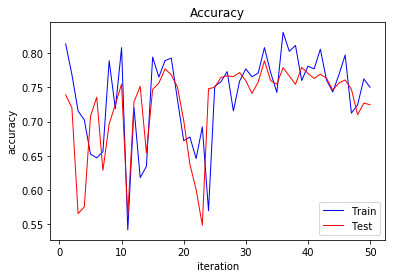

In [95]:
# %%capture
for mn in rk_models: # ['listnet']: # 
    args = {}
    if mn == 'ranknet':
        args = {} # {'batchsize':100, 'n_iter':5000, 'n_units1':512, 'n_units2':128, 'tv_ratio':0.95}
    elif mn == 'listnet':
        args = {'batchsize':100, 'n_epoch':1, 'n_units1':32, 'n_units2':16, 'tv_ratio':0.9}
    rk_models[mn].fit(dummies['train'].values, data_train.QArel, **args)

# clear_output()

In [96]:
for mn in my_models:
    pair_ranker.fit(my_models[mn], mn)

In [97]:
#Series(model_rf.feature_importances_, index=features_trn.columns).sort_values(ascending=False)

In [98]:
sfn = fn.keys() # specify a subset of fn

In [99]:
preds = {k:{mn:md.predict_proba(dummies[k]) for mn, md in models.items()} for k in sfn}

In [100]:
rk_preds = {k:{mn:md.predict(dummies[k].values) for mn, md in rk_models.items()} for k in sfn}

In [101]:
my_preds = {k:{mn:pair_ranker.predict(data[k]['QID'], dummies[k], mn) for mn in my_models} for k in sfn}

In [104]:
ranks = {k:deepcopy(dummies[k]) for k in fn}
dummy_rank_features = {k:deepcopy(dummies[k]) for k in fn}
rank_train, rank_dev, rank_test = ranks['train'], ranks['dev'], ranks['test']
all_tps = tps + tps_wgt + tps_wv + tps_wv_wgt + list(models.keys()) + list(rk_models.keys()) + list(my_models.keys())
for k in sfn:
    rk = ranks[k]
    for col in ['QID', 'QAID']:
        rk[col] = data[k][col]
    if k != 'test':
        rk['QArel'] = data[k]['QArel']
    for mn in models:
        rk[mn] = preds[k][mn][:, 1] # larger is better
    for mn in rk_models:
        rk[mn] = rk_preds[k][mn][:, 0]
    for mn in my_models:
        rk[mn] = my_preds[k][mn]
    grp = rk.groupby('QID')
    for tp in all_tps:
        col = 'rank_' + tp
        rk[col] = grp[tp].rank(method='min', ascending=False).astype(int)  
        rk.sort_values(['QID', col], inplace=True)
        # add one Strictly Increasing Monotonically vector to avoid same ranks
        b = np.ones(rk.shape[0]).cumsum()
        rk[col] += b
        grp = rk.groupby('QID')
        rk[col] = grp[col].rank(method='min', ascending=True).astype(int)  
        dummy_rank_features[k][col] = rk[col]

In [107]:
for k in sfn:
    if k in ['test', 'train']:
        continue
    print(k)
    rk = ranks[k]
    for tp in all_tps:
        col = 'rank_' + tp
        rk.sort_values(['QID', col], inplace=True)
        grp = rk.QArel.groupby(rk.QID)
        print('\t', '{: <20}'.format(tp), np.round([MAP(grp), MRR(grp), MAP(grp, keep_no_ans=False), MRR(grp, keep_no_ans=False)], 5))

dev
	 words                [ 0.31097  0.41728  0.36328  0.48747]
	 stems                [ 0.3127   0.40572  0.3653   0.47398]
	 words_not_stop       [ 0.3127   0.40572  0.3653   0.47398]
	 stems_not_stop       [ 0.32534  0.42724  0.38007  0.49911]
	 lemma                [ 0.31794  0.41104  0.37143  0.48019]
	 lemma_not_stop       [ 0.31794  0.41104  0.37143  0.48019]
	 words_wgt            [ 0.32825  0.42737  0.38347  0.49926]
	 stems_wgt            [ 0.33064  0.43199  0.38626  0.50467]
	 words_not_stop_wgt   [ 0.33064  0.43199  0.38626  0.50467]
	 stems_not_stop_wgt   [ 0.32844  0.43495  0.38369  0.50812]
	 lemma_wgt            [ 0.33064  0.43199  0.38626  0.50467]
	 lemma_not_stop_wgt   [ 0.33064  0.43199  0.38626  0.50467]
	 words_wv             [ 0.29868  0.38913  0.34893  0.45459]
	 stems_wv             [ 0.29628  0.39485  0.34612  0.46127]
	 words_not_stop_wv    [ 0.29628  0.39485  0.34612  0.46127]
	 stems_not_stop_wv    [ 0.30646  0.40514  0.35801  0.4733 ]
	 lemma_wv          

In [108]:
# #res = collections.defaultdict(dict)
# print sfn, '\n'
# print ' ' * 15, '{: >15}\t{: >15}'.format('MAP', 'MRR') 
# for tp in tps + tps_wgt + models.keys() + rk_models.keys() + my_models.keys(): # ['rf']: #
#     print '{: >20}'.format(tp), 
#     for k in sfn:
#         if k in ['test', 'trn']:
#             continue
#         col = 'rank_' + tp
#         ranks[k][['QuestionID', 'SentenceID', col]].sort_values(['QuestionID', col]).to_csv('rank.txt', sep='\t', header=False, index=False)
#         out = commands.getoutput('python eval.py rank.txt %s' % fn[k])
#         m = re.search('MAP: ([.0-9]+)\nMRR ([.0-9]+)', out)
#         print '\t%f\t%f' % (float(m.group(1)), float(m.group(2))),' ',
#     print ''

In [137]:
fn[k]

'data/SemEval2016-Task3-CQA-MD-dev.xml'

In [163]:
def rank_and_evaluate(y, k):
    '''
    if k is 'test', then this func will only rank, not evaluate 
    '''
    d = DataFrame({}, data[k].index)
    d['y'] = y
    cols = ['QID', 'QAID']
    if k != 'test':
        cols.append('QArel')
    for col in cols:
        d[col] = data[k][col]
    
    
    grp = d.groupby('QID')
    d['rank'] = grp['y'].rank(method='min', ascending=False).astype(int)    
    
    d.sort_values(['QID', 'rank'], inplace=True)
    res = dict()
    res['rank_df'] = d
    if k == 'test':
        return res
    grp = d.QArel.groupby(d.QID)
    res['my_MAP'] = MAP(grp, keep_no_ans=False)
    res['my_MRR'] = MRR(grp, keep_no_ans=False)
    d[['QID', 'QAID', 'rank']].sort_values(['QID', 'rank']).to_csv('rank.txt', sep='\t', header=False, index=False)
    fn_tsv = {'train': 'data/train.tsv', 'test': 'data/test.tsv', 'dev': 'data/dev.tsv'}
    out = subprocess.getoutput('python eval.py rank.txt %s' % fn_tsv[k])
    print(out)
    m = re.search('MAP: ([.0-9]+)\nMRR ([.0-9]+)', out)
    res['MAP'] = float(m.group(1))
    res['MRR'] = float(m.group(2))
    return res    

def save_final_rank(df, dst_fn='final_rank.txt', rank_col='rank', 
                    save_cols=['QID', 'QAID', 'rank'], sort_by_cols=['QID', 'rank'], re_rank=False):
    if re_rank:
        col = rank_col
        df.sort_values(['QID', col], inplace=True)
        # add one Strictly Increasing Monotonically vector to avoid same ranks
        b = np.ones(df.shape[0]).cumsum()
        df[col] += b
        grp = df.groupby('QID')
        df[col] = grp[col].rank(method='min', ascending=True).astype(int)  
    df[save_cols].sort_values(sort_by_cols).to_csv(dst_fn, sep='\t', header=False, index=False)    

def resample(rt, Xs, Y):
    if rt == None or rt == 0:
        return Xs, Y
    n = Y.shape[0]
    n1 = Y.sum()
    n0 = n - n1
    cls_idx = np.arange(n)
    pos_cls_idx = cls_idx[Y==1]
    neg_cls_idx = cls_idx[Y==0]
    pos_sample = np.random.choice(pos_cls_idx, size=int(n0 / float(rt)) - n1, )
    new_cls_idx = np.concatenate([neg_cls_idx, pos_cls_idx, pos_sample])
    np.random.shuffle(new_cls_idx)
    print(n0, n1, n, int(n0 / float(rt)) - n1, new_cls_idx.shape)
    new_Y = Y[new_cls_idx]
    new_Xs = [X[new_cls_idx] for X in Xs]
    return new_Xs, new_Y


In [110]:
#ques_len.hist()

In [111]:
#sent_len.hist()
#sent_len[sent_len<200].hist()

In [112]:
from keras.preprocessing.sequence import pad_sequences
sent_pad = dict(zip(sent_seq.keys(), pad_sequences(sent_seq.values(), maxlen=MAX_SENT_SEQUENCE_LENGTH, padding='post', truncating='post')))
ques_pad = dict(zip(ques_seq.keys(), pad_sequences(ques_seq.values(), maxlen=MAX_QUES_SEQUENCE_LENGTH, padding='post', truncating='post')))
ques_as_sent_pad = dict(zip(ques_seq.keys(), pad_sequences(ques_seq.values(), maxlen=MAX_SENT_SEQUENCE_LENGTH, padding='post', truncating='post')))

In [113]:
sent_pad_df = DataFrame(list(sent_pad.values()), index=sent_pad.keys())

In [114]:
ques_pad_df = DataFrame(list(ques_pad.values()), index=ques_pad.keys())

In [115]:
ques_as_sent_pad_df = DataFrame(list(ques_as_sent_pad.values()), index=ques_as_sent_pad.keys())

In [118]:
paddata = collections.defaultdict(dict)
for k in fn:
    paddata[k] = {'ques':ques_pad_df.loc[data[k]['QID']], 
                  'ques_as_sent':ques_as_sent_pad_df.loc[data[k]['QID']],
                  'sent':sent_pad_df.loc[data[k]['ID']]}

In [119]:
num_output_class = 1

In [121]:
label = {}
for k in sfn:
    if k == 'test':
        continue
    tmp = data[k]['QArel'].values
    if num_output_class == 1:
        label[k] = tmp
    elif num_output_class == 2:
        label[k] = np.array([1 - tmp, tmp]).T

In [176]:
data['train'][['QID', 'Qtext', 'QAID', 'QAquestion', 'QArel', 'QAconf']].to_csv('data/train.tsv', sep='\t', encoding='utf8', index=False)

## adapted CNN

In [122]:
use_add_features = True
num_output_class = 1
features_used = dummy_rank_features
add_features_dim = features_used['train'].shape[1] if use_add_features else None
X, Y = {}, {}
for k in sfn:
    X[k] = [paddata[k]['ques'].values, paddata[k]['sent'].values]
    if k != 'test':
        Y[k] = label[k]
    if use_add_features:
        X[k].append(features_used[k].values)

In [123]:
from MyCNN import *
cnn = MyCNN(embedding_matrix, word_index, MAX_QUES_SEQUENCE_LENGTH, MAX_SENT_SEQUENCE_LENGTH, add_features_dim)

In [124]:
cnn.init_model(num_filters=100, filter_size=5, pool_length=2, 
               denses=[100], dropouts=[0], activations=['relu'],
               num_output_class=num_output_class)

D:\QA-rankit\MyCNN.py:27: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(100, 5, padding="same", activation="relu")`
  conv = Conv1D(num_filters, filter_size, border_mode='same', activation='relu')(embedded_sequences)
D:\QA-rankit\MyCNN.py:50: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged = merge(merged_layer_list, mode='concat', concat_axis=1)
c:\python35\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
D:\QA-rankit\MyCNN.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ma..., inputs=[<tf.Tenso...)`
  model = Model(input=merged_input, output=output)


In [126]:
#new_Xs, new_Y = resample(0, X['trn'], Y['trn'])
cnn.fit(X['train'], Y['train'], validation_data=(X['dev'], Y['dev']), nb_epoch=2, batch_size=50) # data['trn'].shape[0]) # 

D:\QA-rankit\MyCNN.py:65: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.model.fit(X, Y, *args, **kwargs)


Train on 30411 samples, validate on 7384 samples
Epoch 1/2


10650/30411 [=========>....................] - ETA: 726s - loss: 2.4659 - acc: 0.460 - ETA: 382s - loss: 2.6990 - acc: 0.490 - ETA: 273s - loss: 3.7252 - acc: 0.520 - ETA: 215s - loss: 3.4012 - acc: 0.550 - ETA: 181s - loss: 3.9888 - acc: 0.540 - ETA: 159s - loss: 3.6104 - acc: 0.560 - ETA: 141s - loss: 3.3214 - acc: 0.545 - ETA: 130s - loss: 3.2431 - acc: 0.550 - ETA: 121s - loss: 3.0060 - acc: 0.522 - ETA: 113s - loss: 2.7788 - acc: 0.532 - ETA: 106s - loss: 2.5798 - acc: 0.545 - ETA: 101s - loss: 2.4384 - acc: 0.545 - ETA: 96s - loss: 2.3024 - acc: 0.546 - ETA: 93s - loss: 2.1870 - acc: 0.54 - ETA: 89s - loss: 2.0857 - acc: 0.54 - ETA: 86s - loss: 1.9987 - acc: 0.54 - ETA: 83s - loss: 1.9199 - acc: 0.54 - ETA: 81s - loss: 1.8458 - acc: 0.55 - ETA: 79s - loss: 1.7883 - acc: 0.55 - ETA: 77s - loss: 1.7421 - acc: 0.55 - ETA: 75s - loss: 1.6955 - acc: 0.55 - ETA: 74s - loss: 1.6474 - acc: 0.55 - ETA: 73s - loss: 1.6032 - acc: 0.55 - ETA: 71s - loss: 1.5676 - acc: 0.55 - ETA: 70s - loss:

21400/30411 [====================>.........] - ETA: 39s - loss: 0.7222 - acc: 0.62 - ETA: 39s - loss: 0.7218 - acc: 0.62 - ETA: 39s - loss: 0.7216 - acc: 0.62 - ETA: 39s - loss: 0.7206 - acc: 0.63 - ETA: 39s - loss: 0.7204 - acc: 0.62 - ETA: 38s - loss: 0.7208 - acc: 0.62 - ETA: 38s - loss: 0.7205 - acc: 0.62 - ETA: 38s - loss: 0.7198 - acc: 0.62 - ETA: 38s - loss: 0.7193 - acc: 0.62 - ETA: 38s - loss: 0.7188 - acc: 0.62 - ETA: 38s - loss: 0.7182 - acc: 0.62 - ETA: 38s - loss: 0.7176 - acc: 0.62 - ETA: 37s - loss: 0.7176 - acc: 0.62 - ETA: 37s - loss: 0.7171 - acc: 0.62 - ETA: 37s - loss: 0.7166 - acc: 0.62 - ETA: 37s - loss: 0.7160 - acc: 0.62 - ETA: 37s - loss: 0.7154 - acc: 0.62 - ETA: 37s - loss: 0.7148 - acc: 0.62 - ETA: 36s - loss: 0.7141 - acc: 0.62 - ETA: 36s - loss: 0.7136 - acc: 0.62 - ETA: 36s - loss: 0.7130 - acc: 0.62 - ETA: 36s - loss: 0.7125 - acc: 0.63 - ETA: 36s - loss: 0.7117 - acc: 0.63 - ETA: 36s - loss: 0.7110 - acc: 0.63 - ETA: 36s - loss: 0.7104 - acc: 0.63 - ETA

30411/30411 [==============================] - ETA: 17s - loss: 0.6534 - acc: 0.64 - ETA: 17s - loss: 0.6532 - acc: 0.64 - ETA: 16s - loss: 0.6531 - acc: 0.64 - ETA: 16s - loss: 0.6530 - acc: 0.64 - ETA: 16s - loss: 0.6529 - acc: 0.64 - ETA: 16s - loss: 0.6526 - acc: 0.64 - ETA: 16s - loss: 0.6523 - acc: 0.64 - ETA: 16s - loss: 0.6521 - acc: 0.64 - ETA: 16s - loss: 0.6519 - acc: 0.64 - ETA: 16s - loss: 0.6518 - acc: 0.64 - ETA: 16s - loss: 0.6514 - acc: 0.64 - ETA: 16s - loss: 0.6513 - acc: 0.64 - ETA: 15s - loss: 0.6513 - acc: 0.64 - ETA: 15s - loss: 0.6513 - acc: 0.64 - ETA: 15s - loss: 0.6508 - acc: 0.64 - ETA: 15s - loss: 0.6507 - acc: 0.64 - ETA: 15s - loss: 0.6501 - acc: 0.64 - ETA: 15s - loss: 0.6502 - acc: 0.64 - ETA: 15s - loss: 0.6501 - acc: 0.64 - ETA: 15s - loss: 0.6499 - acc: 0.64 - ETA: 15s - loss: 0.6498 - acc: 0.64 - ETA: 15s - loss: 0.6495 - acc: 0.64 - ETA: 15s - loss: 0.6493 - acc: 0.64 - ETA: 14s - loss: 0.6490 - acc: 0.64 - ETA: 14s - loss: 0.6487 - acc: 0.64 - ETA

10750/30411 [=========>....................] - ETA: 53s - loss: 0.5922 - acc: 0.76 - ETA: 58s - loss: 0.5627 - acc: 0.74 - ETA: 59s - loss: 0.5656 - acc: 0.71 - ETA: 58s - loss: 0.5644 - acc: 0.69 - ETA: 56s - loss: 0.5559 - acc: 0.70 - ETA: 54s - loss: 0.5535 - acc: 0.70 - ETA: 54s - loss: 0.5621 - acc: 0.69 - ETA: 54s - loss: 0.5589 - acc: 0.68 - ETA: 55s - loss: 0.5480 - acc: 0.69 - ETA: 57s - loss: 0.5441 - acc: 0.69 - ETA: 58s - loss: 0.5621 - acc: 0.68 - ETA: 58s - loss: 0.5572 - acc: 0.68 - ETA: 59s - loss: 0.5503 - acc: 0.68 - ETA: 59s - loss: 0.5457 - acc: 0.69 - ETA: 60s - loss: 0.5447 - acc: 0.69 - ETA: 60s - loss: 0.5483 - acc: 0.68 - ETA: 60s - loss: 0.5484 - acc: 0.68 - ETA: 60s - loss: 0.5527 - acc: 0.68 - ETA: 60s - loss: 0.5525 - acc: 0.68 - ETA: 60s - loss: 0.5536 - acc: 0.68 - ETA: 60s - loss: 0.5550 - acc: 0.68 - ETA: 60s - loss: 0.5595 - acc: 0.67 - ETA: 60s - loss: 0.5584 - acc: 0.67 - ETA: 59s - loss: 0.5616 - acc: 0.67 - ETA: 59s - loss: 0.5620 - acc: 0.67 - ETA

21500/30411 [====================>.........] - ETA: 38s - loss: 0.5623 - acc: 0.67 - ETA: 38s - loss: 0.5626 - acc: 0.67 - ETA: 38s - loss: 0.5624 - acc: 0.67 - ETA: 38s - loss: 0.5620 - acc: 0.68 - ETA: 38s - loss: 0.5615 - acc: 0.68 - ETA: 38s - loss: 0.5615 - acc: 0.68 - ETA: 37s - loss: 0.5606 - acc: 0.68 - ETA: 37s - loss: 0.5610 - acc: 0.68 - ETA: 37s - loss: 0.5610 - acc: 0.68 - ETA: 37s - loss: 0.5611 - acc: 0.68 - ETA: 37s - loss: 0.5613 - acc: 0.68 - ETA: 37s - loss: 0.5613 - acc: 0.68 - ETA: 37s - loss: 0.5611 - acc: 0.68 - ETA: 36s - loss: 0.5615 - acc: 0.68 - ETA: 36s - loss: 0.5612 - acc: 0.68 - ETA: 36s - loss: 0.5614 - acc: 0.68 - ETA: 36s - loss: 0.5620 - acc: 0.68 - ETA: 36s - loss: 0.5624 - acc: 0.68 - ETA: 36s - loss: 0.5628 - acc: 0.68 - ETA: 36s - loss: 0.5625 - acc: 0.68 - ETA: 36s - loss: 0.5625 - acc: 0.68 - ETA: 35s - loss: 0.5624 - acc: 0.68 - ETA: 35s - loss: 0.5627 - acc: 0.68 - ETA: 35s - loss: 0.5622 - acc: 0.68 - ETA: 35s - loss: 0.5620 - acc: 0.68 - ETA

30411/30411 [==============================] - ETA: 14s - loss: 0.5637 - acc: 0.67 - ETA: 14s - loss: 0.5637 - acc: 0.68 - ETA: 14s - loss: 0.5638 - acc: 0.68 - ETA: 14s - loss: 0.5640 - acc: 0.67 - ETA: 14s - loss: 0.5639 - acc: 0.67 - ETA: 14s - loss: 0.5641 - acc: 0.67 - ETA: 14s - loss: 0.5642 - acc: 0.67 - ETA: 14s - loss: 0.5642 - acc: 0.67 - ETA: 14s - loss: 0.5642 - acc: 0.67 - ETA: 14s - loss: 0.5641 - acc: 0.67 - ETA: 14s - loss: 0.5645 - acc: 0.67 - ETA: 13s - loss: 0.5644 - acc: 0.67 - ETA: 13s - loss: 0.5645 - acc: 0.67 - ETA: 13s - loss: 0.5644 - acc: 0.67 - ETA: 13s - loss: 0.5646 - acc: 0.67 - ETA: 13s - loss: 0.5647 - acc: 0.67 - ETA: 13s - loss: 0.5648 - acc: 0.67 - ETA: 13s - loss: 0.5648 - acc: 0.67 - ETA: 13s - loss: 0.5649 - acc: 0.67 - ETA: 13s - loss: 0.5651 - acc: 0.67 - ETA: 13s - loss: 0.5652 - acc: 0.67 - ETA: 13s - loss: 0.5652 - acc: 0.67 - ETA: 12s - loss: 0.5654 - acc: 0.67 - ETA: 12s - loss: 0.5651 - acc: 0.67 - ETA: 12s - loss: 0.5651 - acc: 0.67 - ETA

In [127]:
fn['test']

'data/SemEval2017-Task3-CQA-MD-test.xml'

In [164]:
res = {}
for k in sfn:
    if k in ['train', 'test']:
        continue
    y = cnn.predict(X[k])
    res[k] = rank_and_evaluate(y[:, 0], k)
    print(k)
    for m in ['my_MAP', 'my_MRR', 'MAP', 'MRR']:
        print(m, '\t', res[k][m])

Final Evaluation Score:
MAP: 0.3578925621233751
MRR 0.48956528891621615
dev
my_MAP 	 0.357892562123
my_MRR 	 0.489565288916
MAP 	 0.3578925621233751
MRR 	 0.48956528891621615


In [ ]:
# model.save('model/cnn_2d_%d_%f_%f.h5' % (add_features_dim, res['dev']['MRR'], res['testx']['MRR']))

## adapted LSTM

In [165]:
from MyLSTM import *

In [167]:
# prepare X and Y
use_add_features = True
features_used = dummy_rank_features # dummies 
add_features_dim = features_used['train'].shape[1] if use_add_features else None
X, Y = {}, {}
for k in sfn:
    X[k] = [paddata[k]['ques_as_sent'].values, paddata[k]['sent'].values]
    if k != 'test':
        Y[k] = label[k]
    if use_add_features:
        X[k].append(features_used[k].values)

In [168]:
model = MyLSTM(embedding_matrix, word_index, MAX_SENT_SEQUENCE_LENGTH, add_features_dim)

In [169]:
model.init_model(lstm_output_dim=64, denses=[64], dropouts=[0])

D:\QA-rankit\MyLSTM.py:30: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(64, recurrent_dropout=0)`
  shared_lstm = LSTM(lstm_output_dim,dropout_U=0)
D:\QA-rankit\MyLSTM.py:39: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  merged_vector = merge(merged_layer_list, mode='concat', concat_axis=-1, name='lstm_vec')
c:\python35\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
D:\QA-rankit\MyLSTM.py:44: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`
  self.model = Model(input=merged_input, output=predictions)


In [170]:
#np.random.seed(1337)
model.fit(X['train'], Y['train'], validation_data=(X['dev'], Y['dev']), nb_epoch=2, batch_size=64)

D:\QA-rankit\MyLSTM.py:68: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  self.model.fit(X, Y, *args, **kwargs)


Train on 30411 samples, validate on 7384 samples
Epoch 1/2


13568/30411 [============>.................] - ETA: 687s - loss: 0.7119 - acc: 0.468 - ETA: 389s - loss: 0.7068 - acc: 0.484 - ETA: 289s - loss: 0.7048 - acc: 0.500 - ETA: 234s - loss: 0.7003 - acc: 0.511 - ETA: 205s - loss: 0.6931 - acc: 0.512 - ETA: 183s - loss: 0.6857 - acc: 0.531 - ETA: 168s - loss: 0.6830 - acc: 0.542 - ETA: 159s - loss: 0.6844 - acc: 0.544 - ETA: 149s - loss: 0.6865 - acc: 0.543 - ETA: 143s - loss: 0.6898 - acc: 0.542 - ETA: 137s - loss: 0.6876 - acc: 0.548 - ETA: 131s - loss: 0.6851 - acc: 0.556 - ETA: 128s - loss: 0.6807 - acc: 0.567 - ETA: 124s - loss: 0.6777 - acc: 0.573 - ETA: 120s - loss: 0.6760 - acc: 0.574 - ETA: 118s - loss: 0.6770 - acc: 0.572 - ETA: 115s - loss: 0.6732 - acc: 0.572 - ETA: 113s - loss: 0.6749 - acc: 0.568 - ETA: 110s - loss: 0.6763 - acc: 0.565 - ETA: 108s - loss: 0.6772 - acc: 0.562 - ETA: 106s - loss: 0.6746 - acc: 0.567 - ETA: 104s - loss: 0.6727 - acc: 0.568 - ETA: 102s - loss: 0.6715 - acc: 0.570 - ETA: 100s - loss: 0.6704 - acc: 0

27328/30411 [=========================>....] - ETA: 44s - loss: 0.6248 - acc: 0.63 - ETA: 44s - loss: 0.6246 - acc: 0.63 - ETA: 43s - loss: 0.6245 - acc: 0.63 - ETA: 43s - loss: 0.6244 - acc: 0.63 - ETA: 43s - loss: 0.6241 - acc: 0.63 - ETA: 43s - loss: 0.6239 - acc: 0.63 - ETA: 43s - loss: 0.6240 - acc: 0.63 - ETA: 43s - loss: 0.6239 - acc: 0.63 - ETA: 42s - loss: 0.6237 - acc: 0.63 - ETA: 42s - loss: 0.6235 - acc: 0.63 - ETA: 42s - loss: 0.6236 - acc: 0.63 - ETA: 42s - loss: 0.6235 - acc: 0.63 - ETA: 42s - loss: 0.6234 - acc: 0.63 - ETA: 42s - loss: 0.6232 - acc: 0.63 - ETA: 41s - loss: 0.6228 - acc: 0.63 - ETA: 41s - loss: 0.6230 - acc: 0.63 - ETA: 41s - loss: 0.6230 - acc: 0.63 - ETA: 41s - loss: 0.6231 - acc: 0.63 - ETA: 41s - loss: 0.6233 - acc: 0.63 - ETA: 41s - loss: 0.6232 - acc: 0.63 - ETA: 40s - loss: 0.6231 - acc: 0.63 - ETA: 40s - loss: 0.6234 - acc: 0.63 - ETA: 40s - loss: 0.6233 - acc: 0.63 - ETA: 40s - loss: 0.6230 - acc: 0.63 - ETA: 40s - loss: 0.6228 - acc: 0.63 - ETA

30411/30411 [==============================] - ETA: 8s - loss: 0.6048 - acc: 0.651 - ETA: 7s - loss: 0.6046 - acc: 0.651 - ETA: 7s - loss: 0.6045 - acc: 0.651 - ETA: 7s - loss: 0.6044 - acc: 0.651 - ETA: 7s - loss: 0.6046 - acc: 0.651 - ETA: 7s - loss: 0.6044 - acc: 0.651 - ETA: 7s - loss: 0.6044 - acc: 0.651 - ETA: 6s - loss: 0.6044 - acc: 0.651 - ETA: 6s - loss: 0.6043 - acc: 0.651 - ETA: 6s - loss: 0.6043 - acc: 0.651 - ETA: 6s - loss: 0.6044 - acc: 0.651 - ETA: 6s - loss: 0.6042 - acc: 0.652 - ETA: 6s - loss: 0.6042 - acc: 0.652 - ETA: 5s - loss: 0.6043 - acc: 0.651 - ETA: 5s - loss: 0.6044 - acc: 0.651 - ETA: 5s - loss: 0.6044 - acc: 0.651 - ETA: 5s - loss: 0.6042 - acc: 0.651 - ETA: 5s - loss: 0.6041 - acc: 0.651 - ETA: 5s - loss: 0.6041 - acc: 0.651 - ETA: 4s - loss: 0.6040 - acc: 0.651 - ETA: 4s - loss: 0.6038 - acc: 0.652 - ETA: 4s - loss: 0.6038 - acc: 0.652 - ETA: 4s - loss: 0.6038 - acc: 0.652 - ETA: 4s - loss: 0.6038 - acc: 0.652 - ETA: 4s - loss: 0.6036 - acc: 0.652 - ETA

13632/30411 [============>.................] - ETA: 135s - loss: 0.5005 - acc: 0.703 - ETA: 138s - loss: 0.5434 - acc: 0.687 - ETA: 137s - loss: 0.5373 - acc: 0.692 - ETA: 128s - loss: 0.5432 - acc: 0.695 - ETA: 126s - loss: 0.5611 - acc: 0.675 - ETA: 121s - loss: 0.5592 - acc: 0.679 - ETA: 116s - loss: 0.5569 - acc: 0.671 - ETA: 122s - loss: 0.5507 - acc: 0.685 - ETA: 122s - loss: 0.5531 - acc: 0.684 - ETA: 125s - loss: 0.5631 - acc: 0.668 - ETA: 124s - loss: 0.5651 - acc: 0.667 - ETA: 121s - loss: 0.5695 - acc: 0.664 - ETA: 119s - loss: 0.5635 - acc: 0.670 - ETA: 117s - loss: 0.5694 - acc: 0.662 - ETA: 116s - loss: 0.5772 - acc: 0.657 - ETA: 114s - loss: 0.5739 - acc: 0.662 - ETA: 112s - loss: 0.5762 - acc: 0.662 - ETA: 110s - loss: 0.5724 - acc: 0.665 - ETA: 108s - loss: 0.5713 - acc: 0.664 - ETA: 106s - loss: 0.5730 - acc: 0.663 - ETA: 107s - loss: 0.5708 - acc: 0.665 - ETA: 108s - loss: 0.5690 - acc: 0.669 - ETA: 109s - loss: 0.5698 - acc: 0.669 - ETA: 108s - loss: 0.5710 - acc: 0

27392/30411 [==========================>...] - ETA: 65s - loss: 0.5703 - acc: 0.68 - ETA: 65s - loss: 0.5703 - acc: 0.68 - ETA: 65s - loss: 0.5700 - acc: 0.68 - ETA: 65s - loss: 0.5700 - acc: 0.68 - ETA: 65s - loss: 0.5703 - acc: 0.68 - ETA: 65s - loss: 0.5701 - acc: 0.68 - ETA: 65s - loss: 0.5701 - acc: 0.68 - ETA: 64s - loss: 0.5702 - acc: 0.68 - ETA: 64s - loss: 0.5703 - acc: 0.68 - ETA: 64s - loss: 0.5704 - acc: 0.68 - ETA: 64s - loss: 0.5705 - acc: 0.68 - ETA: 63s - loss: 0.5705 - acc: 0.68 - ETA: 63s - loss: 0.5710 - acc: 0.68 - ETA: 63s - loss: 0.5708 - acc: 0.68 - ETA: 62s - loss: 0.5708 - acc: 0.68 - ETA: 62s - loss: 0.5707 - acc: 0.68 - ETA: 62s - loss: 0.5710 - acc: 0.68 - ETA: 61s - loss: 0.5708 - acc: 0.68 - ETA: 61s - loss: 0.5707 - acc: 0.68 - ETA: 61s - loss: 0.5706 - acc: 0.68 - ETA: 60s - loss: 0.5705 - acc: 0.68 - ETA: 60s - loss: 0.5706 - acc: 0.68 - ETA: 60s - loss: 0.5706 - acc: 0.68 - ETA: 59s - loss: 0.5713 - acc: 0.68 - ETA: 59s - loss: 0.5711 - acc: 0.68 - ETA

30411/30411 [==============================] - ETA: 10s - loss: 0.5676 - acc: 0.68 - ETA: 10s - loss: 0.5677 - acc: 0.68 - ETA: 10s - loss: 0.5677 - acc: 0.68 - ETA: 10s - loss: 0.5676 - acc: 0.68 - ETA: 9s - loss: 0.5678 - acc: 0.6869 - ETA: 9s - loss: 0.5677 - acc: 0.686 - ETA: 9s - loss: 0.5678 - acc: 0.686 - ETA: 9s - loss: 0.5678 - acc: 0.686 - ETA: 8s - loss: 0.5679 - acc: 0.687 - ETA: 8s - loss: 0.5678 - acc: 0.687 - ETA: 8s - loss: 0.5679 - acc: 0.687 - ETA: 8s - loss: 0.5680 - acc: 0.687 - ETA: 8s - loss: 0.5681 - acc: 0.687 - ETA: 7s - loss: 0.5681 - acc: 0.687 - ETA: 7s - loss: 0.5680 - acc: 0.687 - ETA: 7s - loss: 0.5681 - acc: 0.687 - ETA: 7s - loss: 0.5682 - acc: 0.686 - ETA: 6s - loss: 0.5683 - acc: 0.686 - ETA: 6s - loss: 0.5683 - acc: 0.686 - ETA: 6s - loss: 0.5681 - acc: 0.687 - ETA: 6s - loss: 0.5680 - acc: 0.687 - ETA: 5s - loss: 0.5680 - acc: 0.687 - ETA: 5s - loss: 0.5682 - acc: 0.687 - ETA: 5s - loss: 0.5681 - acc: 0.687 - ETA: 5s - loss: 0.5681 - acc: 0.687 - ET

In [171]:
res = {}
for k in sfn:
    if k in ['train', 'test']:
        continue
    y = model.predict(X[k])
    res['y'] = y
    res[k] = rank_and_evaluate(y, k)
    print(k)
    for m in ['my_MAP', 'my_MRR', 'MAP', 'MRR']:
        print(m, '\t', res[k][m])

Final Evaluation Score:
MAP: 0.3624145282547332
MRR 0.49511843677687817
dev
my_MAP 	 0.362414528255
my_MRR 	 0.495118436777
MAP 	 0.3624145282547332
MRR 	 0.49511843677687817


In [172]:
# model.save('model/lstm_2d_%d_%f_%f.h5' % (add_features_dim, res['dev']['MRR'], res['testx']['MRR']))

In [173]:
# from keras.models import load_model
# model = load_model('model/lstm.1337.709692.663293.h5')

## predict and save

In [182]:
# predict on test dataset
k = 'test'
y = model.predict(X[k])
tres = rank_and_evaluate(y, k)
save_final_rank(tres['rank_df'], dst_fn='final_rank.txt', rank_col='rank', 
                    save_cols=['QID', 'QAID', 'rank', 'y'], sort_by_cols=['QID', 'rank'], re_rank=False)

print('Done')

Done


In [181]:
tres

{'rank_df':                      y    QID    QAID  rank
 ID                                         
 66711*380008  0.935079  66711  380008     1
 66711*115106  0.923309  66711  115106     2
 66711*355209  0.913477  66711  355209     3
 66711*499827  0.733337  66711  499827     4
 66711*280600  0.665984  66711  280600     5
 66711*46944   0.590208  66711   46944     6
 66711*195574  0.517899  66711  195574     7
 66711*78260   0.516698  66711   78260     8
 66711*882992  0.485483  66711  882992     9
 66713*182904  0.941843  66713  182904     1
 66713*309036  0.932637  66713  309036     2
 66713*352144  0.860052  66713  352144     3
 66713*58127   0.818538  66713   58127     4
 66713*93012   0.802518  66713   93012     5
 66713*648111  0.690899  66713  648111     6
 66713*31036   0.663684  66713   31036     7
 66713*38495   0.585776  66713   38495     8
 66713*24877   0.524117  66713   24877     9
 66715*829322  0.957426  66715  829322     1
 66715*42543   0.939296  66715   42543     2